# LIBRARIES


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# INISIASI DATASET


In [22]:
# import
SENTIMENT_DATASET_FILE_NAME = "sentiment.csv"
SENTIMENT_DATASET_FILE_PATH = f"outputs/{SENTIMENT_DATASET_FILE_NAME}"
DATA_FRAME_SENTIMENT_DATASET = pd.read_csv(SENTIMENT_DATASET_FILE_PATH)
DATA_FRAME_SENTIMENT_DATASET_LENGTH = len(DATA_FRAME_SENTIMENT_DATASET)
print(f"labelled dataset: {DATA_FRAME_SENTIMENT_DATASET_LENGTH} tweets")
display(DATA_FRAME_SENTIMENT_DATASET.tail(1))
sentiment = DATA_FRAME_SENTIMENT_DATASET

labelled dataset: 4913 tweets


,user_id,username,user_display_name,tweet_id,full_text,created_at,cleaned_text,after_slang_text,underscore_negation_text,swap_negation_text,final_negation_text,is_different,after_stopwords_text,after_stemming_text,preprocessed_text,compound_score,sentistrength_score,sentiment_label,sentistrength_label
4912,1497098972443602944,RismaII4,Risma II 🇮🇩🇮🇩🇮🇩,1839477624550412418,Sebuah langkah besar menuju masa depan yang le...,Fri Sep 27 01:30:16 +0000 2024,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,sebuah langkah besar menuju masa depan yang le...,False,langkah berkesinambungan inklusif dukungan pem...,langkah sambung inklusif dukung bangun kota ne...,langkah sambung inklusif dukung bangun kota ne...,-0.0192,0.875,negatif,positif


In [62]:
# temp = pd.DataFrame()
# temp["text"] = ["pindah kota semangat indonesia maju", "jokowi daerah ibukota negara tulang punggung tahan pangan kota peluang daerah kalimantan timur kembang sektor tani ikan integrasi", "gara paksa bikin kota negara paksa sih", "ditawarin sosok bikin taman analisanya pikir bikin park garden pilih ngelanjutin mindah kota pusing"]
# temp["sentiment"] = ["netral", "positif", "negatif", "negatif"]
# temp

In [63]:
# from sklearn.feature_extraction.text import CountVectorizer

# # term frequency
# tf = CountVectorizer()
# tf_matrix = tf.fit_transform(temp["text"])
# count_tf = pd.DataFrame(tf_matrix.toarray(), columns=tf.get_feature_names_out())
# count_tf

# # doc frequency
# df = CountVectorizer()
# df_matrix = df.fit_transform(temp["text"])
# count_df = pd.DataFrame(df_matrix.toarray(), columns=df.get_feature_names_out())
# df_values = (count_df > 0).sum(axis=0)
# df_df = pd.DataFrame({'Term': df.get_feature_names_out(), 'DF': df_values})
# print(df_df.to_string(index=False))

# # N / df(t)
# ndf = CountVectorizer()
# ndf_x = ndf.fit_transform(temp["text"])
# ndf_shape = ndf_x.shape[0]
# df_count = pd.DataFrame(ndf_x.toarray(), columns=ndf.get_feature_names_out())
# df_values = (df_count > 0).sum(axis=0)
# nd_df_values = ndf_shape / df_values
# nd_df_df = pd.DataFrame({'Term': ndf.get_feature_names_out(), 'Nd/DF(t)': nd_df_values})
# print(nd_df_df.to_string(index=False))

# # inverse document frequency
# temp_tfidf = TfidfVectorizer()
# fit_temp_tfidf = temp_tfidf.fit_transform(temp["text"])
# idf_values = temp_tfidf.idf_
# idf_df = pd.DataFrame({'Term': temp_tfidf.get_feature_names_out(), 'IDF': idf_values})
# print(idf_df)

# # term frequency-inverse document frequency
# temp_tfidf_ = TfidfVectorizer()
# tfidf_matrix = temp_tfidf_.fit_transform(temp["text"])
# tfidf_df_ = pd.DataFrame(tfidf_matrix.toarray(), columns=temp_tfidf_.get_feature_names_out())
# print(tfidf_df_.to_string(index=False))
# tfidf_df_.to_csv("outputs/tfidf.csv", index=False)

# TF-IDF


In [23]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(sentiment["preprocessed_text"])

# SMOTE


In [24]:
smote = SMOTE(random_state=21)
X_smote, Y_smote = smote.fit_resample(X_tfidf, sentiment["sentiment_label"])

In [28]:
ss_smote = SMOTE(random_state=21)
X_smote_ss, Y_smote_ss = ss_smote.fit_resample(X_tfidf, sentiment["sentistrength_label"])

# DATA SPLIT


In [25]:
X_train_9010,X_test_9010,Y_train_9010,Y_test_9010=train_test_split(X_smote, Y_smote, test_size=0.1, random_state=21)
X_train_8020,X_test_8020,Y_train_8020,Y_test_8020=train_test_split(X_smote, Y_smote, test_size=0.2, random_state=21)
X_train_7030,X_test_7030,Y_train_7030,Y_test_7030=train_test_split(X_smote, Y_smote, test_size=0.3, random_state=21)

In [29]:
X_train_9010_ss,X_test_9010_ss,Y_train_9010_ss,Y_test_9010_ss=train_test_split(X_smote_ss, Y_smote_ss, test_size=0.1, random_state=21)
X_train_8020_ss,X_test_8020_ss,Y_train_8020_ss,Y_test_8020_ss=train_test_split(X_smote_ss, Y_smote_ss, test_size=0.2, random_state=21)
X_train_7030_ss,X_test_7030_ss,Y_train_7030_ss,Y_test_7030_ss=train_test_split(X_smote_ss, Y_smote_ss, test_size=0.3, random_state=21)

# KNN


| 70:30 split |
| k = 1 |
              precision    recall  f1-score   support

     negatif       0.70      0.91      0.79       631
      netral       0.85      0.56      0.67       636
     positif       0.77      0.81      0.79       623

    accuracy                           0.76      1890
   macro avg       0.77      0.76      0.75      1890
weighted avg       0.77      0.76      0.75      1890

| accuracy: 0.76 |
| precision: 0.7737769822679658 |
| recall: 0.7576719576719577 |
| f1: 0.7509251212345233 |


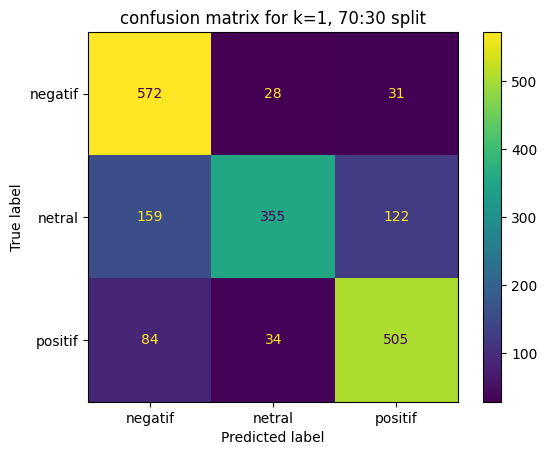

| 70:30 split |
| k = 3 |
              precision    recall  f1-score   support

     negatif       0.68      0.91      0.78       631
      netral       0.88      0.51      0.65       636
     positif       0.76      0.81      0.78       623

    accuracy                           0.75      1890
   macro avg       0.77      0.75      0.74      1890
weighted avg       0.77      0.75      0.74      1890

| accuracy: 0.75 |
| precision: 0.7729302911375565 |
| recall: 0.7455026455026456 |
| f1: 0.7363507420360107 |


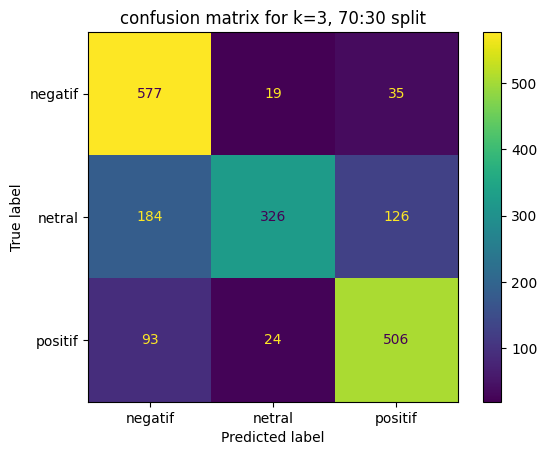

| 70:30 split |
| k = 5 |
              precision    recall  f1-score   support

     negatif       0.65      0.92      0.77       631
      netral       0.91      0.47      0.62       636
     positif       0.75      0.80      0.77       623

    accuracy                           0.73      1890
   macro avg       0.77      0.73      0.72      1890
weighted avg       0.77      0.73      0.72      1890

| accuracy: 0.73 |
| precision: 0.7701446877311199 |
| recall: 0.7317460317460317 |
| f1: 0.7200614440844323 |


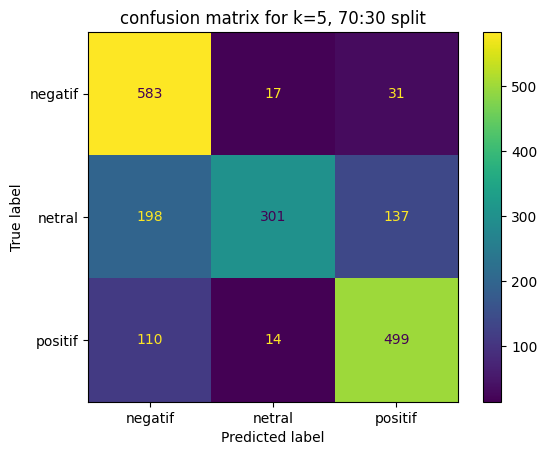

| 70:30 split |
| k = 7 |
              precision    recall  f1-score   support

     negatif       0.63      0.93      0.75       631
      netral       0.90      0.43      0.58       636
     positif       0.75      0.79      0.77       623

    accuracy                           0.71      1890
   macro avg       0.76      0.71      0.70      1890
weighted avg       0.76      0.71      0.70      1890

| accuracy: 0.71 |
| precision: 0.7595027155987191 |
| recall: 0.7137566137566138 |
| f1: 0.6993656536621659 |


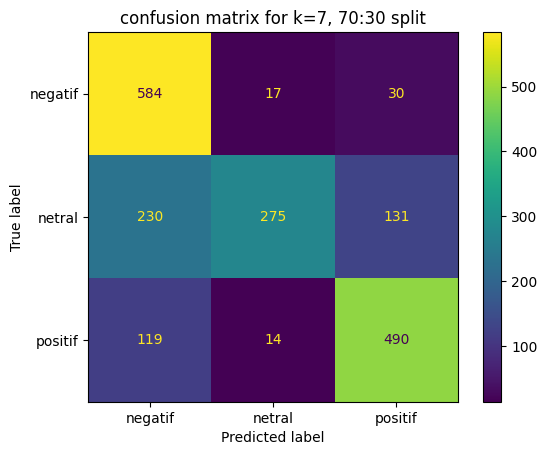

In [ ]:
def train_evaluate_knn(k, X_train, Y_train, X_test, Y_test, ratio):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='weighted')
    recall = recall_score(Y_test, y_pred, average='weighted')
    f1 = f1_score(Y_test, y_pred, average='weighted')

    print("===============================================================")
    print(f"| {ratio} split |")
    print(f"| k = {k} |")
    print("===============================================================")
    print(classification_report(Y_test, y_pred, target_names=knn.classes_))
    print("===============================================================")
    
    print(f"| accuracy: {accuracy:.2f} |")
    print(f"| precision: {precision} |")
    print(f"| recall: {recall} |")
    print(f"| f1: {f1} |")
    print("===============================================================")
    
    cm = confusion_matrix(Y_test, y_pred, labels=knn.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
    disp.plot()
    plt.title(f"confusion matrix for k={k}, {ratio} split")
    plt.show()
    
    return knn

# knn1_9010 = train_evaluate_knn(1, X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10")
# knn3_9010 = train_evaluate_knn(3, X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10")
# knn5_9010 = train_evaluate_knn(5, X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10")
# knn7_9010 = train_evaluate_knn(7, X_train_9010, Y_train_9010, X_test_9010, Y_test_9010, "90:10")

# knn1_8020 = train_evaluate_knn(1, X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20")
# knn3_8020 = train_evaluate_knn(3, X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20")
# knn5_8020 = train_evaluate_knn(5, X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20")
# knn7_8020 = train_evaluate_knn(7, X_train_8020, Y_train_8020, X_test_8020, Y_test_8020, "80:20")

# knn1_7030 = train_evaluate_knn(1, X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30")
# knn3_7030 = train_evaluate_knn(3, X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30")
# knn5_7030 = train_evaluate_knn(5, X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30")
# knn7_7030 = train_evaluate_knn(7, X_train_7030, Y_train_7030, X_test_7030, Y_test_7030, "70:30")

# knn1_9010_ss = train_evaluate_knn(1, X_train_9010_ss, Y_train_9010_ss, X_test_9010_ss, Y_test_9010_ss, "90:10")
# knn3_9010_ss = train_evaluate_knn(3, X_train_9010_ss, Y_train_9010_ss, X_test_9010_ss, Y_test_9010_ss, "90:10")
# knn5_9010_ss = train_evaluate_knn(5, X_train_9010_ss, Y_train_9010_ss, X_test_9010_ss, Y_test_9010_ss, "90:10")
# knn7_9010_ss = train_evaluate_knn(7, X_train_9010_ss, Y_train_9010_ss, X_test_9010_ss, Y_test_9010_ss, "90:10")

# knn1_8020_ss = train_evaluate_knn(1, X_train_8020_ss, Y_train_8020_ss, X_test_8020_ss, Y_test_8020_ss, "80:20")
# knn3_8020_ss = train_evaluate_knn(3, X_train_8020_ss, Y_train_8020_ss, X_test_8020_ss, Y_test_8020_ss, "80:20")
# knn5_8020_ss = train_evaluate_knn(5, X_train_8020_ss, Y_train_8020_ss, X_test_8020_ss, Y_test_8020_ss, "80:20")
# knn7_8020_ss = train_evaluate_knn(7, X_train_8020_ss, Y_train_8020_ss, X_test_8020_ss, Y_test_8020_ss, "80:20")

# knn1_7030_ss = train_evaluate_knn(1, X_train_7030_ss, Y_train_7030_ss, X_test_7030_ss, Y_test_7030_ss, "70:30")
# knn3_7030_ss = train_evaluate_knn(3, X_train_7030_ss, Y_train_7030_ss, X_test_7030_ss, Y_test_7030_ss, "70:30")
# knn5_7030_ss = train_evaluate_knn(5, X_train_7030_ss, Y_train_7030_ss, X_test_7030_ss, Y_test_7030_ss, "70:30")
# knn7_7030_ss = train_evaluate_knn(7, X_train_7030_ss, Y_train_7030_ss, X_test_7030_ss, Y_test_7030_ss, "70:30")

# DUMP KNN MODEL AND TF-IDF VECTORIZER


In [27]:
def save_model(model, filename):
    with open(filename, 'wb') as model_file:
            joblib.dump(model, model_file)

# save_model(knn1_9010, 'models/9010/knn1_9010_model.pkl')

# save_model(tfidf, 'models/tf-idf/tfidf_vectorizer.pkl')